In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import RandomizedSearchCV
import warnings

In [3]:
df = pd.read_csv('data/stud.csv')

In [4]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Target column is 'math_score'

### Lets seprate the target variable from df so that we can work on the training data

In [5]:
X = df.drop(columns=['math_score'], axis=1)

In [6]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [7]:
print(f"Categories in gender column: {df['gender'].unique()} --> {len(df['gender'].unique())}")
print(f"Categories in race_ethnicity column: {df['race_ethnicity'].unique()} --> {len(df['race_ethnicity'].unique())}")
print(f"Categories in parental_level_of_education column: {df['parental_level_of_education'].unique()} --> {len(df['parental_level_of_education'].unique())}")
print(f"Categories in gender column: {df['lunch'].unique()} --> {len(df['lunch'].unique())}")
print(f"Categories in gender column: {df['test_preparation_course'].unique()} --> {len(df['test_preparation_course'].unique())}")

Categories in gender column: ['female' 'male'] --> 2
Categories in race_ethnicity column: ['group B' 'group C' 'group A' 'group D' 'group E'] --> 5
Categories in parental_level_of_education column: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school'] --> 6
Categories in gender column: ['standard' 'free/reduced'] --> 2
Categories in gender column: ['none' 'completed'] --> 2


In [8]:
cat_column = [c for c in df.columns if df[c].dtype == object]
for c in cat_column:
    print(f"Categories in gender column: {df[c].unique()} --> {len(df[c].unique())}")

Categories in gender column: ['female' 'male'] --> 2
Categories in gender column: ['group B' 'group C' 'group A' 'group D' 'group E'] --> 5
Categories in gender column: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school'] --> 6
Categories in gender column: ['standard' 'free/reduced'] --> 2
Categories in gender column: ['none' 'completed'] --> 2


In [9]:
y = df['math_score']
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

# Create Column Transformer with 3 types of transformers

In [10]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", numeric_transformer, num_features),
        ("StandardScaler", oh_transformer, cat_features)
    ]
)

In [11]:
X = preprocessor.fit_transform(X) # --> converts x(dataframe) too x(nparray)

In [12]:
X

array([[ 0.19399858,  0.39149181,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 1.42747598,  1.31326868,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 1.77010859,  1.64247471,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.12547206, -0.20107904,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.60515772,  0.58901542,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 1.15336989,  1.18158627,  1.        , ...,  0.        ,
         0.        ,  1.        ]])

- df --> x + y
- df --> X and y(target)
- X --> X.preprocessing and y

- X(preprocessed), y --> X_train(preprocessed), X_test(preprocessed), y_train, y_test

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

- [X_train + y_train] --> goes for training
- [X_test + y_test] ----> goes for testing

In [14]:
X_train.shape, X_test.shape, y_train.shape

((800, 19), (200, 19), (800,))

#### Evaluation function

In [15]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# --> models + training + prediction + evaluation

In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = [] # -->stores model name --> will use for creating df
r2_list =[] # -->stores model r2_score --> will use for creating df

for i in range(len(list(models))):
    model = list(models.values())[i] # --> model = model_object

    # 1)Train model
    model.fit(X_train, y_train)

    # 2) Make prediction
    y_train_pred = model.predict(X_train) #--> Prediction on TRAINING DATA
    y_test_pred = model.predict(X_test) #--> Prediction on TEST DATA

    # 3) Evaluate data --> both train data + test data
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    #4)
    print("***Model Performance for Training set***")
    print("- Root mean Squared Error:", model_train_rmse)
    print("- Mean Absolute Error:", model_train_mae)
    print("- R2 score:", model_train_r2)

    print('----------------------------------')

    print("***Model Performance for Test set***")
    print("- Root mean Squared Error:", model_test_rmse)
    print("- Mean Absolute Error:", model_test_mae)
    print("- R2 score:", model_test_r2)

    #5)
    model_list.append(list(models.keys())[i]) # --> stores current model name
    r2_list.append(model_test_r2) # --> stores r2_score of current data

    print('='*35)
    print('\n')




***Model Performance for Training set***
- Root mean Squared Error: 5.323050852720514
- Mean Absolute Error: 4.266711846071956
- R2 score: 0.8743172040139593
----------------------------------
***Model Performance for Test set***
- Root mean Squared Error: 5.3939938697328405
- Mean Absolute Error: 4.214763142474849
- R2 score: 0.8804332983749565


***Model Performance for Training set***
- Root mean Squared Error: 6.593807540619166
- Mean Absolute Error: 5.206296077972952
- R2 score: 0.8071466723085148
----------------------------------
***Model Performance for Test set***
- Root mean Squared Error: 6.519688056285626
- Mean Absolute Error: 5.157879138921816
- R2 score: 0.825320079562973


***Model Performance for Training set***
- Root mean Squared Error: 5.323324922741654
- Mean Absolute Error: 4.264987823725981
- R2 score: 0.8743042615212909
----------------------------------
***Model Performance for Test set***
- Root mean Squared Error: 5.390387016935639
- Mean Absolute Error: 4.21

In [17]:
df2 = pd.DataFrame({
    'Model Name': model_list,
    'R2 Score': r2_list
})
df2 = df2.sort_values(by='R2 Score', ascending=False)

In [18]:
df2

,Model Name,R2 Score
2,Ridge,0.880593
0,Linear Regression,0.880433
7,CatBoosting Regressor,0.851632
5,Random Forest Regressor,0.848713
8,AdaBoost Regressor,0.847774
1,Lasso,0.825320
6,XGBRegressor,0.821221
3,K-Neighbors Regressor,0.783770
4,Decision Tree,0.755690


### RIdge and Linear Regressoin has the best results. choosing Linear Regression 

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)
print("Accuracy of the model is:", score)

Accuracy of the model is: 0.8804332983749565


In [20]:
print(lin_model.intercept_)

65.52357656600951


#### plot y_pred and y_test

Text(0, 0.5, 'Predicted')

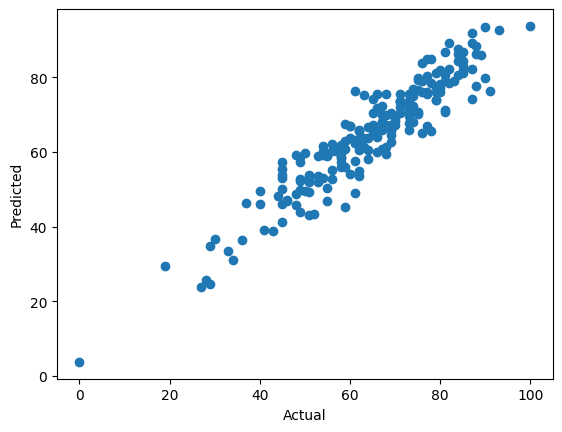

In [22]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

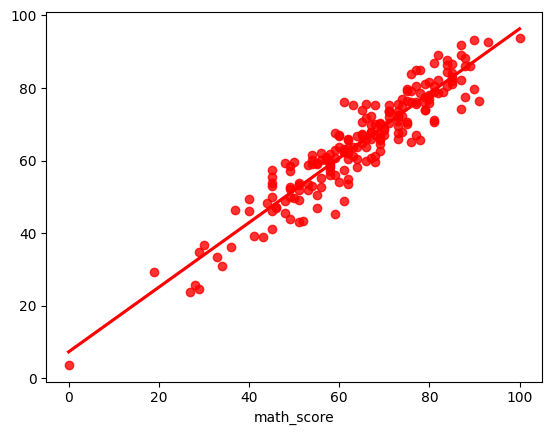

In [24]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

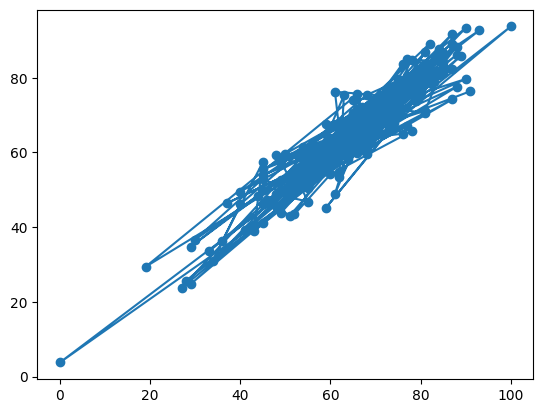

In [27]:
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_pred)